In [1]:
import pandas as pd
import numpy as np

np.set_printoptions(legacy="1.25")

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"
)

In [3]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [4]:
df.isna().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [5]:
for col in ["num_cylinders", "horsepower", "acceleration", "num_doors"]:
    df[col] = df[col].fillna(0)

In [6]:
df.isna().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [7]:
numerical_vars = [
    "engine_displacement",
    "num_cylinders",
    "horsepower",
    "vehicle_weight",
    "acceleration",
    "num_doors",
]
target_variable = "fuel_efficiency_mpg"
categorical_vars = list(set(df.columns) - set(numerical_vars) - set([target_variable]))

In [8]:
from sklearn.model_selection import train_test_split

train_ratio = 0.60
test_ratio = 0.20
validation_ratio = 0.20

# train is now 60% of the entire data set
# test is 40% but we will split it again
df_train, df_test = train_test_split(
    df,
    test_size=1 - train_ratio,
    random_state=1,
)

# test is now 20% of the initial data set
# validation is now 20% of the initial data set
df_test, df_val = train_test_split(
    df_test,
    test_size=test_ratio / (test_ratio + validation_ratio),
    random_state=1,
)

y_train = df_train[target_variable].values
y_test = df_test[target_variable].values
y_val = df_val[target_variable].values

df_train = df_train.drop(columns=target_variable)
df_test = df_test.drop(columns=target_variable)
df_val = df_val.drop(columns=target_variable)

np.array([df_train.shape[0], df_val.shape[0], df_test.shape[0]]) / df.shape[0]

array([0.59995878, 0.20002061, 0.20002061])

In [9]:
from sklearn.feature_extraction import DictVectorizer

train_dicts = df_train.to_dict(orient="records")

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)

In [10]:
X_train.shape

(5822, 14)

# 1. Which feature is used for splitting the data? (DecisionTreeRegressor)

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [12]:
val_dicts = df_val.to_dict(orient="records")
X_val = dv.transform(val_dicts)
y_pred = dt.predict(X_val)

In [13]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- vehicle_weight <= 3028.82
|   |--- value: [16.86]
|--- vehicle_weight >  3028.82
|   |--- value: [12.87]



# 2. What's the RMSE of this model on the validation data? (RandomForestRegressor)

In [14]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [15]:
y_pred = rf.predict(X_val)

In [16]:
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(y_true=y_val, y_pred=y_pred)

In [17]:
rmse

0.4551388553934271

# 3. After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the answer.

In [38]:
rmses = []
nestimators = np.arange(10, 210, 10)
for ne in nestimators:
    rf = RandomForestRegressor(n_estimators=ne, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    rmses.append(rmse)

Text(0.5, 1.0, 'N estimators vs RMSE')

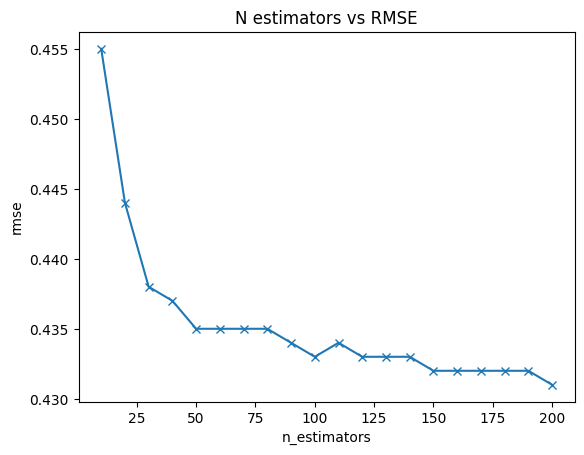

In [44]:
import matplotlib.pyplot as plt

rmses = pd.DataFrame([nestimators, rmses], index=["nestimator", "rmse"]).T
plt.plot(rmses.nestimator, round(rmses.rmse, 3), "x-")
plt.xlabel("n_estimators")
plt.ylabel("rmse")
plt.title("N estimators vs RMSE")

In [51]:
rmses.loc[np.argmin(rmses.rmse)]

nestimator    200.000000
rmse            0.431203
Name: 19, dtype: float64

# 4. What's the best max_depth, using the mean RMSE?

In [28]:
max_depths = [10, 15, 20, 25]
mean_rmses = []
# nestimators np.arange(10,201,10)
for md in max_depths:
    print(f"{md=}")
    rmses = []
    for ne in nestimators:
        rf = RandomForestRegressor(
            n_estimators=ne, random_state=1, n_jobs=-1, max_depth=md
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        rmses.append(rmse)

    mean_rmse = np.mean(rmses)
    mean_rmses.append(mean_rmse)

    print(f"{mean_rmse=}")
    print()

md=10
mean_rmse=0.43270457107998617

md=15
mean_rmse=0.435276257964495

md=20
mean_rmse=0.43508685965167243

md=25
mean_rmse=0.4353073066333188



In [32]:
max_depths[np.argmin([round(x, 3) for x in mean_rmses])]

10

# Feature Importance

In [68]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

In [85]:
importance_df = pd.DataFrame(
    {
        "feature": dv.get_feature_names_out(),
        "importance": rf.feature_importances_,
    }
).sort_values("importance", ascending=False)
importance_df

,feature,importance
13,vehicle_weight,0.959829
6,horsepower,0.015943
0,acceleration,0.011458
3,engine_displacement,0.003190
7,model_year,0.003065
8,num_cylinders,0.002329
9,num_doors,0.001564
12,origin=USA,0.000474
10,origin=Asia,0.000429
11,origin=Europe,0.000425


# Which eta leads to the best RMSE score on the validation dataset?

In [93]:
import xgboost as xgb

features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [101]:
xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)
y_pred = model.predict(dval)
root_mean_squared_error(y_val, y_pred)

0.45420193807929243

In [102]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)
y_pred = model.predict(dval)
root_mean_squared_error(y_val, y_pred)

0.428430075669781